In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#from IPython.core.pylabtools import figure

#from pandas.plotting import register_matplitlib_converters
#register_matplotlib_converters()

import seaborn as sns

In [2]:
# Link to dataset "https://archive.ics.uci.edu/ml/datasets/GPS+Trajectories"

In [3]:
path = r"C:\Users\Gaurav\Downloads\WowLabz\WowLabz_mobility_prediction\Dataset"
file = r"\go_track_trackspoints.csv"

In [4]:
df = pd.read_csv(path+file, parse_dates = ['time'], index_col = "time")
df.pop('id')

time
2014-09-13 07:24:32        1
2014-09-13 07:24:37        2
2014-09-13 07:24:42        3
2014-09-13 07:24:47        4
2014-09-13 07:24:53        5
                       ...  
2016-01-19 13:01:01    19565
2016-01-19 13:01:12    19566
2016-01-19 13:01:24    19567
2016-01-19 13:01:36    19568
2016-01-19 13:01:47    19569
Name: id, Length: 18107, dtype: int64

C:\Users\Gaurav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

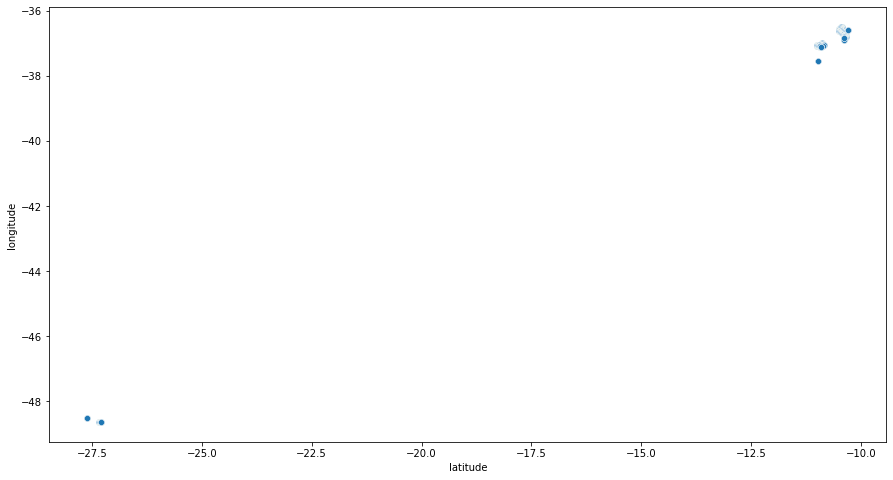

In [5]:
plt.figure(figsize = (15,8))
sns.scatterplot(df['latitude'], df['longitude'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 18107 entries, 2014-09-13 07:24:32 to 2016-01-19 13:01:47
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   latitude   18107 non-null  float64
 1   longitude  18107 non-null  float64
 2   track_id   18107 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 565.8 KB


In [7]:
df.describe()

,latitude,longitude,track_id
count,18107.000000,18107.000000,18107.000000
mean,-10.998744,-37.111923,13296.340697
std,1.329848,0.938015,18040.767448
min,-27.603175,-48.632918,1.000000
25%,-10.944041,-37.073069,33.000000
50%,-10.922000,-37.057784,136.000000
75%,-10.904268,-37.050190,37992.000000
max,-10.292845,-36.493357,38092.000000


In [8]:
df

,latitude,longitude,track_id
time,,,
2014-09-13 07:24:32,-10.939341,-37.062742,1
2014-09-13 07:24:37,-10.939341,-37.062742,1
2014-09-13 07:24:42,-10.939324,-37.062765,1
2014-09-13 07:24:47,-10.939211,-37.062843,1
2014-09-13 07:24:53,-10.938939,-37.062879,1
...,...,...,...
2016-01-19 13:01:01,-10.923722,-37.106579,38092
2016-01-19 13:01:12,-10.923704,-37.106693,38092
2016-01-19 13:01:24,-10.923715,-37.106688,38092


In [9]:
# Checking number of data points per track_id
df.groupby("track_id").count()

,latitude,longitude
track_id,,
1,90,90
2,113,113
3,23,23
4,129,129
8,20,20
...,...,...
38081,122,122
38082,134,134
38084,4,4


In [10]:
# Removing values where records are less than 50
sub_df = df[df.groupby('track_id').latitude.transform('count')>50].copy()
sub_df

,latitude,longitude,track_id
time,,,
2014-09-13 07:24:32,-10.939341,-37.062742,1
2014-09-13 07:24:37,-10.939341,-37.062742,1
2014-09-13 07:24:42,-10.939324,-37.062765,1
2014-09-13 07:24:47,-10.939211,-37.062843,1
2014-09-13 07:24:53,-10.938939,-37.062879,1
...,...,...,...
2015-11-23 22:24:32,-10.944160,-37.088702,38082
2015-11-23 22:24:42,-10.943978,-37.089421,38082
2015-11-23 22:24:50,-10.943601,-37.089233,38082


In [11]:
sub_df.groupby("track_id").count()

,latitude,longitude
track_id,,
1,90,90
2,113,113
4,129,129
11,108,108
13,180,180
...,...,...
38077,71,71
38079,103,103
38080,57,57


In [12]:
df = sub_df

C:\Users\Gaurav\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='latitude', ylabel='longitude'>

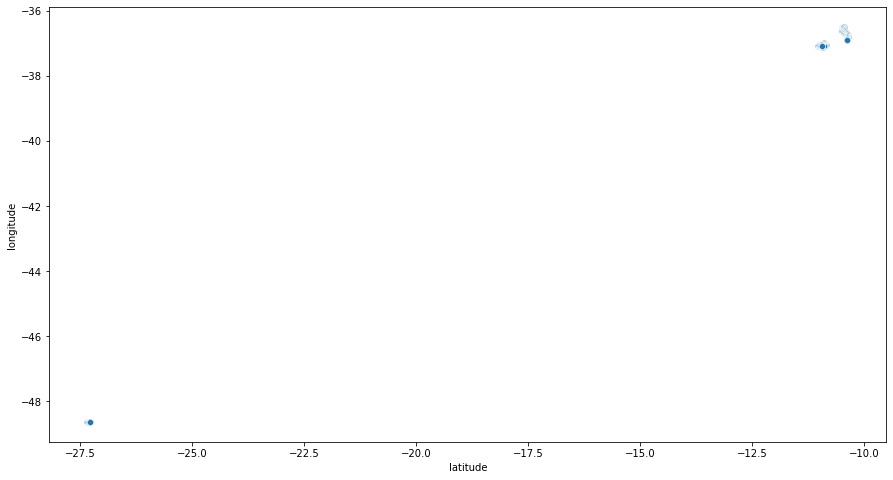

In [13]:
plt.figure(figsize = (15,8))
sns.scatterplot(df['latitude'], df['longitude'])

In [14]:
# Set random seed for reproducibility
tf.random.set_seed(1234)

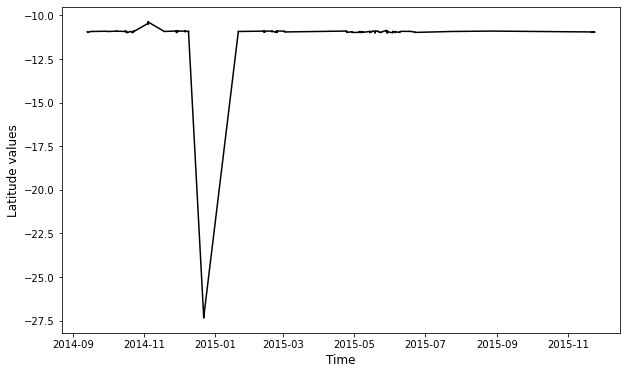

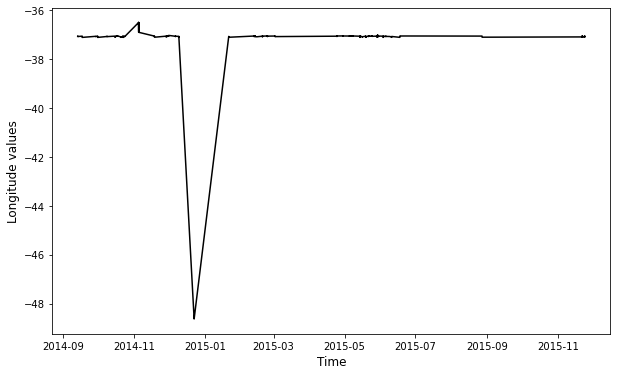

In [15]:
# Define a function to draw time_series plot
def timeseries (x_axis, y_axis, x_label, y_label):
    plt.figure(figsize = (10, 6))
    plt.plot(x_axis, y_axis, color ='black')
    plt.xlabel(x_label, {'fontsize': 12}) 
    plt.ylabel(y_label, {'fontsize': 12})
timeseries(df.index, df['latitude'], 'Time','Latitude values')
timeseries(df.index, df['longitude'], 'Time','Longitude values')

In [16]:
# Check missing values
df.isnull().sum()

latitude     0
longitude    0
track_id     0
dtype: int64

Dimension of train data:  (13952, 3)
Dimension of test data:  (3488, 3)


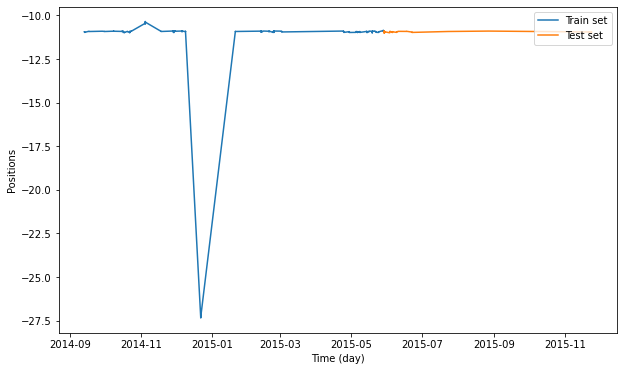

In [17]:
# Split train data and test data
train_size = int(len(df)*0.8)
train_dataset, test_dataset = df.iloc[:train_size], df.iloc[train_size:]

# Plot train and test data
plt.figure(figsize = (10, 6))
plt.plot(train_dataset.latitude)
plt.plot(test_dataset.latitude)
plt.xlabel('Time (day)')
plt.ylabel('Positions')
plt.legend(['Train set', 'Test set'], loc='upper right')
print('Dimension of train data: ',train_dataset.shape)
print('Dimension of test data: ', test_dataset.shape)

In [18]:
# Split train data to X and y
X_train = train_dataset.drop('track_id', axis = 1)
y_train = train_dataset.drop('track_id', axis = 1)

# Split test data to X and y
X_test = test_dataset.drop('track_id', axis = 1)
y_test = test_dataset.drop('track_id', axis = 1)

In [19]:
# Different scaler for input and output
#scaler_x = MinMaxScaler(feature_range = (0,1))
#scaler_y = MinMaxScaler(feature_range = (0,1))

# Fit the scaler using available training data
#input_scaler = scaler_x.fit(X_train)
#output_scaler = scaler_y.fit(y_train)

# Apply the scaler to training data
#train_y_norm = output_scaler.transform(y_train)
#train_x_norm = input_scaler.transform(X_train)

# Apply the scaler to test data
#test_y_norm = output_scaler.transform(y_test)
#test_x_norm = input_scaler.transform(X_test)

train_y_norm = y_train.to_numpy()
train_x_norm = X_train.to_numpy()

test_y_norm = y_test.to_numpy()
test_x_norm = X_test.to_numpy()

In [20]:
# Create a 3D input
def create_dataset (X, y, time_steps = 1):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)
TIME_STEPS = 50
X_test, y_test = create_dataset(test_x_norm, test_y_norm,   
                                TIME_STEPS)
X_train, y_train = create_dataset(train_x_norm, train_y_norm, 
                                  TIME_STEPS)
print('X_train.shape: ', X_test.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_train.shape)

X_train.shape:  (3458, 30, 2)
y_train.shape:  (13922, 2)
X_test.shape:  (3458, 30, 2)
y_test.shape:  (13922, 2)


In [21]:
# Create BiLSTM model
def create_model_bilstm(units):
    model = Sequential()
    model.add(Bidirectional(LSTM(units = units,                             
              return_sequences=True),
              input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(2))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# Create LSTM or GRU model
def create_model(units, m):
    model = Sequential()
    model.add(m (units = units, return_sequences = True,
                input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2))
    model.add(m (units = units))
    model.add(Dropout(0.2))
    model.add(Dense(units = 2))
    #Compile model
    model.compile(loss='mse', optimizer='adam')
    return model
# BiLSTM
model_bilstm = create_model_bilstm(64)
# GRU and LSTM
model_gru = create_model(64, GRU)
model_lstm = create_model(64, LSTM)

In [22]:
# Fit BiLSTM, LSTM and GRU
def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 10,  
                        validation_split = 0.2, batch_size = 32, 
                        shuffle = False, callbacks = [early_stop])
    return history
history_bilstm = fit_model(model_bilstm)
history_lstm = fit_model(model_lstm)
history_gru = fit_model(model_gru)

Epoch 1/20
349/349 [==============================] - 16s 32ms/step - loss: 214.5408 - val_loss: 0.0698
Epoch 2/20
349/349 [==============================] - 10s 27ms/step - loss: 1.0032 - val_loss: 0.0012
Epoch 3/20
349/349 [==============================] - 10s 28ms/step - loss: 0.9928 - val_loss: 7.5490e-04
Epoch 4/20
349/349 [==============================] - 10s 28ms/step - loss: 0.9964 - val_loss: 8.8626e-04
Epoch 5/20
349/349 [==============================] - 9s 27ms/step - loss: 0.9997 - val_loss: 8.9183e-04
Epoch 6/20
349/349 [==============================] - 9s 27ms/step - loss: 1.0029 - val_loss: 8.3347e-04
Epoch 7/20
349/349 [==============================] - 10s 27ms/step - loss: 1.0059 - val_loss: 8.0465e-04
Epoch 8/20
349/349 [==============================] - 9s 27ms/step - loss: 1.0088 - val_loss: 8.1082e-04
Epoch 9/20
349/349 [==============================] - 10s 28ms/step - loss: 1.0115 - val_loss: 8.4019e-04
Epoch 10/20
349/349 [==============================] - 

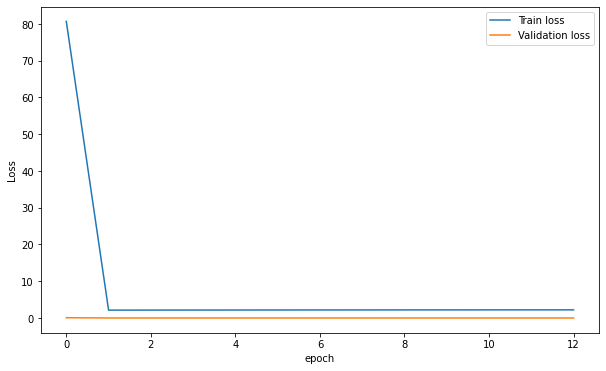

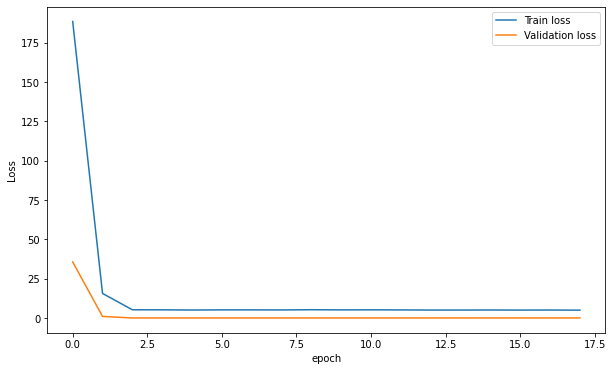

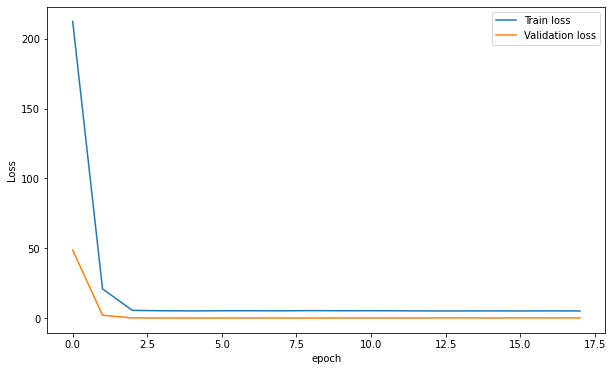

In [23]:
# Plot train loss and validation loss
def plot_loss (history):
    plt.figure(figsize = (10, 6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('Loss')
    plt.xlabel('epoch')
    plt.legend(['Train loss', 'Validation loss'], loc='upper right')
plot_loss (history_bilstm)
plot_loss (history_lstm)
plot_loss (history_gru)

In [25]:
#y_test = scaler_y.inverse_transform(y_test)
#y_train = scaler_y.inverse_transform(y_train)

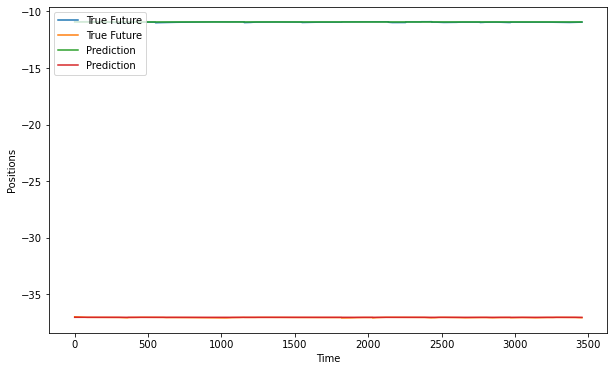

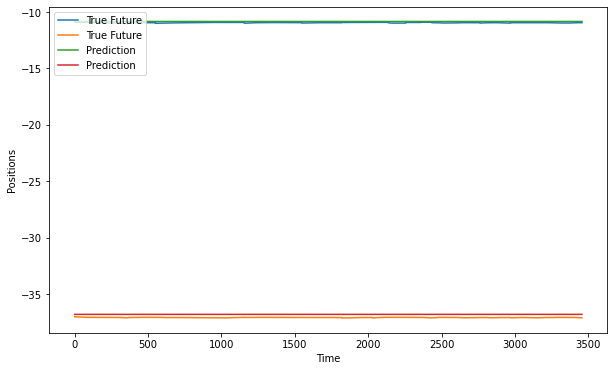

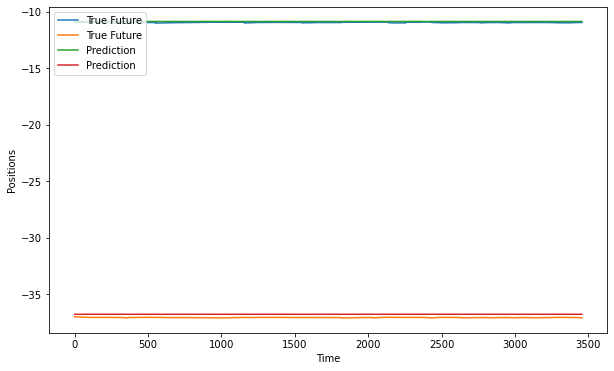

In [29]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    #prediction = scaler_y.inverse_transform(prediction)
    return prediction
prediction_bilstm = prediction(model_bilstm)
prediction_lstm = prediction(model_lstm)
prediction_gru = prediction(model_gru)

# Plot true future vs prediction
def plot_future(prediction, y_test):
    plt.figure(figsize=(10, 6))
    range_future = len(prediction)
    plt.plot(np.arange(range_future), np.array(y_test), 
             label='True Future')     
    plt.plot(np.arange(range_future),np.array(prediction),
            label='Prediction')
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Positions')
plot_future(prediction_bilstm, y_test)
plot_future(prediction_lstm, y_test)
plot_future(prediction_gru, y_test)

In [30]:
# Define a function to calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectional LSTM')
evaluate_prediction(prediction_lstm, y_test, 'LSTM')
evaluate_prediction(prediction_gru, y_test, 'GRU')

Bidirectional LSTM:
Mean Absolute Error: 0.0211
Root Mean Square Error: 0.0263

LSTM:
Mean Absolute Error: 0.1949
Root Mean Square Error: 0.2138

GRU:
Mean Absolute Error: 0.1908
Root Mean Square Error: 0.2152



# For a new point -14.998912565549357, -39.31812497043452

In [31]:
X_new = X_test[0,0].reshape(-1, 2)
X_new

array([[-10.98785375, -37.05628288]])

In [33]:
# Plot histoy and future data
def plot_history_future(y_train, prediction):
    plt.figure(figsize=(10, 6))
    range_history = len(y_train)
    range_future = list(range(range_history, range_history +
                   len(prediction)))
    plt.plot(np.arange(range_history), np.array(y_train), 
             label='History')
    plt.plot(range_future, np.array(prediction),label='Prediction')
    plt.legend(loc='upper right')
    plt.xlabel('Time')
    plt.ylabel('Position')
    
# Multi-step forecasting 
def forecast(X_input, time_steps):
    # Scale the unseen input with the scaler fitted on the train set
    #X = input_scaler.transform(X_input)
    # Reshape unseen data to a 3D input
    Xs = []
    for i in range(len(X) - time_steps):
        v = X[i:i+time_steps, :]
        Xs.append(v)
    X_transformed = np.array(Xs)
    # Make prediction for unseen data using LSTM model
    prediction = model_bilstm.predict(X_transformed)
    prediction_actual = scaler_y.inverse_transform(prediction)
    return prediction_actual
prediction = forecast(X_new, TIME_STEPS)
plot_history_future(y_train, prediction)

NameError: name 'X' is not defined